## Solving the Mason-Weaver equation

see: 

- Midelet, J.; El-Sagheer, A. H.; Brown, T.; Kanaras, A. G.; Werts, M. H. V.  
"The Sedimentation of Colloidal Nanoparticles in  Solution and Its Study Using Quantitative Digital Photography."  
*Part. Part. Syst. Charact.* **2017**, *34*, 1700095. https://doi.org/10.1002/ppsc.201700095.  
Solving the Mason-Weaver equation with a finite-difference scheme.


- Barthe, L.; Werts, M. H. V.  
"Sedimentation of colloidal nanoparticles in fluids: efficient and robust numerical evaluation of analytic solutions of the Mason-Weaver equation".  
*ChemRXiv* **2022**. [doi:10.26434/chemrxiv-2022-91vrq](https://doi.org/10.26434/chemrxiv-2022-91vrq)  
Exact analytic solutions, requiring specific numerical evaluation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyfvtool as pf

In [2]:
# physical parameters defining the Mason-Weaver system
z_max = 1.0
D_coeff = 0.015
sg = 0.2

In [3]:
# FVM calculation parameters
Nx = 100
Lx = z_max
dt = 0.01
t_simulation = 10.
Nskip = 50 # for plotting

In [4]:
msh = pf.Grid1D(Nx, Lx)

In [5]:
# Solution variable (default no flux BCs)
c = pf.CellVariable(msh, 1.0)

In [6]:
# start list, monitoring the total amount of matter in system 
# (integral of concentration over full volume)
total_c = [c.domainIntegral()]

In [7]:
# advection field (constant sedimentation)
u = pf.FaceVariable(msh, (sg,))
# closed boundaries: no flow at extremities
u.xvalue[0] = 0.0
u.xvalue[-1] = 0.0

In [8]:
# diffusion field (constant diffusion)
D = pf.FaceVariable(msh, D_coeff)

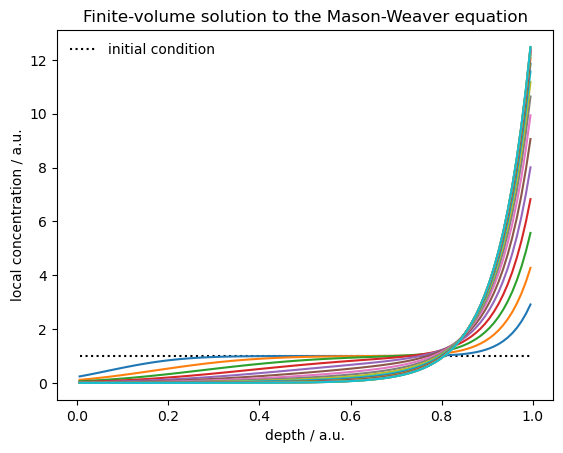

In [9]:
# plot initial condition
plt.plot(c.cellcenters.x, c.value, 'k:', label = 'initial condition')

# time loop
it = 0

while (it*dt < t_simulation):
    # In the present implementation, also the 'constant' terms
    # (boundaryConditionsTerm, diffusionTerm and convectionTerm)
    # are re-constructed every cycle. This is done for clarity.
    # Code can be 'optimized' by constructing these terms outside
    # of the loop and store their results. The difference in performance is 
    # probably minimal, since most of the CPU time is in the
    # actual solving of the matrix equation
    eqnterms = [ pf.transientTerm(c, dt, 1.0),
                -pf.diffusionTerm(D),
                 pf.convectionTerm(u)]

    pf.solvePDE(c, eqnterms)
    it+=1
    total_c.append(c.domainIntegral())
    if (it % Nskip == 0):
        plt.plot(c.cellcenters.x, c.value)

plt.xlabel('depth / a.u.')
plt.ylabel('local concentration / a.u.')
plt.legend(frameon=False)
plt.title('Finite-volume solution to the Mason-Weaver equation');

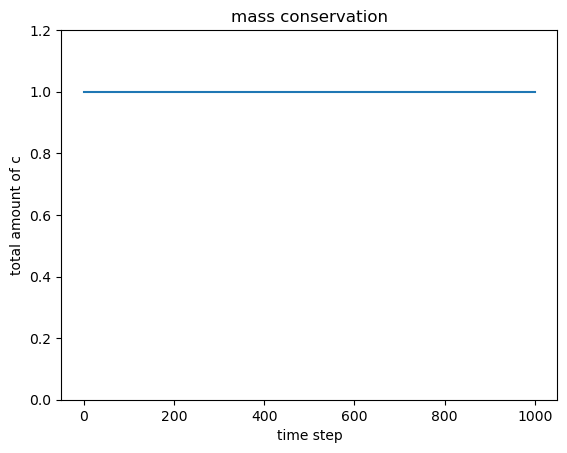

In [10]:
plt.plot(total_c)
plt.ylabel('total amount of c')
plt.xlabel('time step')
plt.ylim(0, 1.2*np.max(total_c))
plt.title('mass conservation');

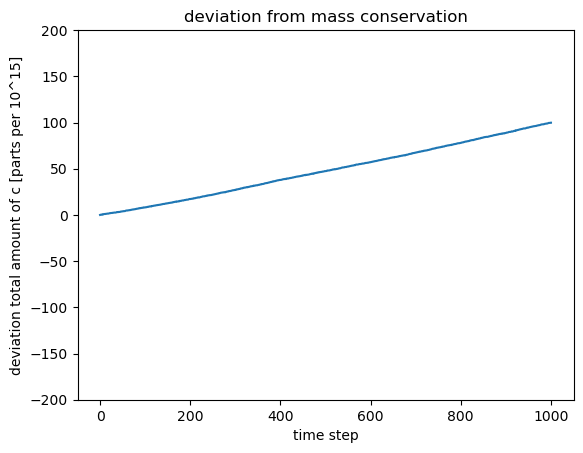

In [11]:
total_dev = np.array(1e15*(total_c-total_c[0])/total_c[0])
plt.plot(total_dev)
plt.ylabel('deviation total amount of c [parts per 10^15]')
plt.ylim(-200, 200)
plt.xlabel('time step')
plt.title('deviation from mass conservation');

In [12]:
# deviation from mass conservation should be less than 1 part in 1e12
# in this case

maxdev_ppq = 1000. # max rel deviation in parts per 10^15
assert np.max(np.abs(total_dev)) < maxdev_ppq

In [13]:
# amplitude of steady-state solution
z0 = D_coeff/sg
B = z_max/(z0*(1.0-np.exp(-z_max/z0)))

# simulation should have reached at least 90% of steady-state value
# 
assert np.max(c.value) > 0.9*B